In [1]:
import os
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV 

% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


In [2]:
input_path  = 'data/temps_extended.csv'
dataset = pd.read_csv(input_path)
dataset.head()

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39


In [3]:
y = dataset['actual']
X = dataset.drop(['actual'],axis =1)

In [4]:
X.head()

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,39


In [5]:
days  = dataset['day']
months = dataset['month']
years = dataset['year']

dates = [str(int(y)) +'-'+str(int(m))+'-'+str(int(d)) for y,m,d  in  zip(years,months,days)]
recorded_date = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [6]:
X['recorded_date'] = recorded_date

In [7]:
month_to_season = {1:'winter',2:'winter',12:'winter',
                   3:'spring',4:'spring',5:'spring',
                   6:'summer',7:'summer',8:'summer',
                   9:'fall',10:'fall',11:'fall'
                   }
X['season'] = X['month'].map(month_to_season)

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state =42)

In [9]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1643, 13)
Training Labels Shape: (1643,)
Testing Features Shape: (548, 13)
Testing Labels Shape: (548,)


In [10]:
from datatools.customtransformers import DummyTransformer
dt = DummyTransformer(['week','season'])
X_train = dt.fit_transform(X_train)
X_test = dt.transform(X_test)

In [11]:
not_considered=['recorded_date']
not_in_basemodel =['ws_1','prcp_1','snwd_1','season_fall','season_spring','season_summer','season_winter']
original_feature  = [ feature for feature in X_train.columns.values 
                         if feature not in not_considered + not_in_basemodel]
 

In [12]:
print('Training Features Shape:', X_train[original_feature].shape)

Training Features Shape: (1643, 14)


In [13]:
X_train[original_feature].head()

,year,month,day,temp_2,temp_1,average,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
561,2012,7,16,77,66,76.1,90,0,1,0,0,0,0,0
393,2012,1,29,44,44,48.5,38,0,0,0,1,0,0,0
2055,2016,8,19,80,87,76.2,91,1,0,0,0,0,0,0
534,2012,6,19,66,63,70.4,70,0,0,0,0,0,1,0
30,2011,1,31,48,44,48.7,53,0,1,0,0,0,0,0


In [14]:
X_trainBase =X_train[original_feature]
X_testBase =X_test[original_feature]

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators =1000,random_state =42)
rf.fit(X_trainBase,y_train)
y_predBase = rf.predict(X_trainBase)
base_errors  = abs(y_predBase -y_train)

print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(base_errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
baseline_mape = 100 * np.mean((base_errors / y_train))

# Calculate and display accuracy
baseline_accuracy = 100 - baseline_mape
print('Accuracy:', round(baseline_accuracy, 2), '%.')

Metrics for Random Forest Trained on Original Data
Average absolute error: 1.46 degrees.
Accuracy: 97.58 %.


In [16]:
y_predBase = rf.predict(X_testBase)
base_errors  = abs(y_predBase -y_test)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(base_errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
baseline_mape = 100 * np.mean((base_errors / y_test))

# Calculate and display accuracy
baseline_accuracy = 100 - baseline_mape
print('Accuracy:', round(baseline_accuracy, 2), '%.')

Metrics for Random Forest Trained on Original Data
Average absolute error: 3.73 degrees.
Accuracy: 93.72 %.


In [17]:
features  = [ feature for feature in X_train.columns.values 
                         if feature not in not_considered ]
X_train =X_train[features]
X_test =X_test[features]

In [18]:
X_train.head()

,year,month,day,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed,season_fall,season_spring,season_summer,season_winter
561,2012,7,16,8.50,0.00,0,77,66,76.1,90,0,1,0,0,0,0,0,0,0,1,0
393,2012,1,29,4.92,0.00,0,44,44,48.5,38,0,0,0,1,0,0,0,0,0,0,1
2055,2016,8,19,9.62,0.00,0,80,87,76.2,91,1,0,0,0,0,0,0,0,0,1,0
534,2012,6,19,8.50,0.12,0,66,63,70.4,70,0,0,0,0,0,1,0,0,0,1,0
30,2011,1,31,10.74,0.00,0,48,44,48.7,53,0,1,0,0,0,0,0,0,0,0,1


In [19]:
print('Training Features Shape:', X_train.shape)

Training Features Shape: (1643, 21)


In [20]:
rf.fit(X_train,y_train)
y_predBase = rf.predict(X_test)
pred_errors  = abs(y_predBase -y_test)

print('Metrics for Random Forest')
print('Average absolute error:', round(np.mean(base_errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
pred_mape = 100 * np.mean((pred_errors / y_test))

# Calculate and display accuracy
accuracy = 100 - pred_mape
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest
Average absolute error: 3.73 degrees.
Accuracy: 93.75 %.


In [21]:
# Compare to baseline
improvement_baseline = 100 * abs(pred_mape - baseline_mape) / baseline_mape
print('Improvement over baseline:', round(improvement_baseline, 2), '%.')

Improvement over baseline: 0.44 %.


In [22]:
feature_importance = pd.DataFrame ({ 'feature' : list(X_train.columns.values),
                                     'importance':list(rf.feature_importances_) })
 
feature_importance = feature_importance.sort_values(['importance'],ascending =False)

feature_importance

,feature,importance
7,temp_1,0.8336
8,average,0.0608
3,ws_1,0.0223
9,friend,0.0165
6,temp_2,0.0149
2,day,0.0138
0,year,0.0098
4,prcp_1,0.0076
1,month,0.0045
10,week_Fri,0.0025


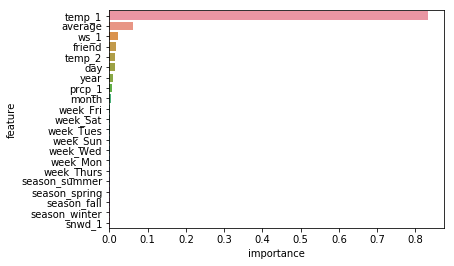

In [23]:
ax = sns.barplot(y="feature", x="importance", data=feature_importance )

In [33]:
top_6_features = feature_importance[0:7]['feature'].tolist()
top_6_features 

['temp_1', 'average', 'ws_1', 'friend', 'temp_2', 'day', 'year']

In [26]:
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
X_train_select = X_train[top_6_features]
X_test_select = X_test[top_6_features]

In [35]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train_select, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=2)

In [37]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [36]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [38]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
base_model.fit(X_train_select, y_train)
evaluate(base_model, X_test_select, y_test)

Model Performance
Average Error: 3.7829 degrees.
Accuracy = 93.63%.


In [39]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)

In [40]:
grid_search.fit(X_train_select, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  8.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [41]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [42]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, X_test_select, y_test)


Model Performance
Average Error: 3.6783 degrees.
Accuracy = 93.79%.
